# Keras model

* Let's try with neural networks !

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

Using Theano backend.


* Load train data:

In [2]:
data_train = pd.read_csv("data/train.csv")
data_train.drop("id", axis = 1, inplace=True)

* Load test data:

In [3]:
data_test = pd.read_csv("data/test.csv")
ids = data_test.values[:, 0]
data_test.drop("id", axis = 1, inplace=True)

* Concatenate train and test datasets in order to fit the transformers, so that we encounter no unknown categories when transforming:

In [4]:
#Concatenate test and train:
whole_categ_data = pd.concat( [ data_train.iloc[:,0:116], data_test.iloc[:,0:116] ], ignore_index=True ).iloc[:, 0:116]

#Fit label encoder:
from collections import defaultdict
label_encoder = defaultdict( preprocessing.LabelEncoder )
whole_categ_data = whole_categ_data.apply(lambda x: label_encoder[x.name].fit_transform(x) )

#Transform test and train with label encoding
data_train.iloc[:, 0:116] = data_train.iloc[:,0:116].apply(lambda x: label_encoder[x.name].transform(x) )
data_test.iloc[:, 0:116] = data_test.iloc[:,0:116].apply(lambda x: label_encoder[x.name].transform(x) )

#Fit one hot encoder
one_hot_encoder = preprocessing.OneHotEncoder( sparse = False )
one_hot_encoder.fit( whole_categ_data.values )

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

* Extract features and target:

In [5]:
X = data_train.values[:, :-1]
y = data_train.values[:, -1]

* Transform train with one hot encoding

In [6]:
labels = one_hot_encoder.transform( X[:,:116] )
X = np.hstack( ( labels ,  X[:,116:] ) )
print X.shape

(188318, 1190)


* Shuffle (will probably be useless, just to avoid mistakes due to forgotten shuffling)

In [7]:
X, y = utils.shuffle(X, y)

* Function to build our Keras neural network:

In [8]:
def create_model(params):
    nn = Sequential()

    #Layers
    for i in xrange( params['n_layers'] ):
        if i == 0 : #Input layer
            nn.add( Dense( params['n_units'] , input_dim=X.shape[1]) )
        else: #Hidden layers
            nn.add( Dense( params['n_units']) )
            
        if( params['activation'] == 'prelu' ) : 
            nn.add( PReLU() )
        elif( params['activation'] == 'relu' ):
            nn.add( Activation( 'relu' ) )   
        if( params['dropout'] != 0.0 ) : nn.add( Dropout(params['dropout']) )
        
    #Output
    nn.add( Dense(1) )
    nn.compile(loss='mae', optimizer='adam')
    
    return nn

* Contrary to what I did with xgboost I will not perform k-fold cross validation when optimizing because it's sooo long on a laptop with no gpu :(

In [9]:
from hyperopt import hp
from hyperopt import fmin, STATUS_OK, tpe, space_eval
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU

def score(params):  
    print "Training with params : "
    print params
    
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')
    model = create_model(params)
    
    fit = model.fit( X, y, nb_epoch=100, batch_size=128, verbose=0, validation_split=0.2, callbacks=[early_stopping] )
    
    hist = fit.history
    print 'MAE val score:', hist['val_loss'][-1]
  
    return {'loss': hist['val_loss'][-1], 'status': STATUS_OK}

* The optimization has been done in a terminal since it's not possible to ctrl + z then fg when inside a notebook :(

In [10]:
#Find best
space = {
             'n_layers' : hp.choice('n_layers', [1, 2, 3, 4]),
             'n_units' :  hp.choice('n_units', [128, 256, 512, 1024]),
             'activation' : hp.choice('activation', ['relu', 'prelu']),
             'dropout' : hp.uniform('dropout', 0.1, 0.9)
             }

#best = fmin(score, space, algo=tpe.suggest, max_evals=2)
#best = space_eval(space, best)

#Terminal result :
best = {'n_units': 1024, 'activation': 'prelu', 'n_layers': 2, 'dropout': 0.61}

* Let's have a look at our best model performance (we already know the result from the optimisation script but let's put it in the notebook) :

In [11]:
model = create_model(best)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')
fit = model.fit( X, y, nb_epoch=100, batch_size=128, verbose=0, validation_split=0.2, callbacks=[early_stopping] )
    
hist = fit.history
print 'MAE val score:', hist['val_loss'][-1]

MAE val score: 1145.30055666


* Plot train and validation MAE as a function of the epoch:

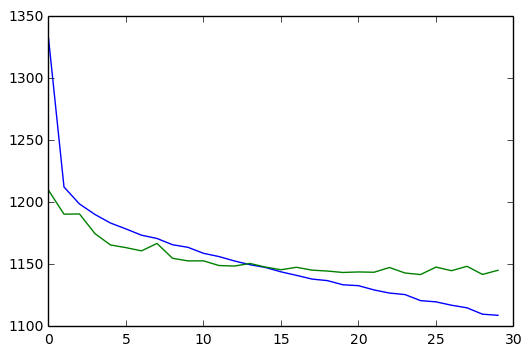

In [12]:
plt.plot( range( len(hist['loss']) ), hist['loss'] )
plt.plot( range( len(hist['loss']) ), hist['val_loss'] )

* Now we can train on the whole dataset:

In [13]:
keras_model = create_model(best)
fit = keras_model.fit( X, y, nb_epoch=30, batch_size=128, verbose=0 )

* And predict the target on the test set:

In [14]:
X = data_test.values

labels = one_hot_encoder.transform( X[:,:116] )
X = np.hstack( ( labels ,  X[:,116:] ) )

pred = model.predict(X)[:, 0]

submission = pd.DataFrame( {'id': ids, 'loss': pred } )
submission.to_csv('keras_predictions.csv', index = False)

* Our MAE score on kaggle (after the end of the competition) is 1143.7 with this model.